Version 1.0.0

# Introduction

In this programming assignment we will illustrate a very severe data leakage, that can often be found in competitions, where the pairs of object should be scored, e.g. predict $1$ if two objects belong to the same class and $0$ otherwise. 

The data in this assignment is taken from a real competition, and the funniest thing is that *we will not use training set at all* and achieve almost 100% accuracy score! We will just exploit the leakage.

Now go through the notebook and complete the assignment.

In [25]:
import numpy as np
import pandas as pd 
import scipy.sparse
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

# Load the data

Let's load the test data. Note, that we don't have any training data here, just test data. Moreover, *we will not even use any features* of test objects. All we need to solve this task is the file with the indices for the pairs, that we need to compare.

Let's load the data with test indices.

In [97]:
test = pd.read_csv('../readonly/data_leakages_data/test_pairs.csv')
test.head(10)

,pairId,FirstId,SecondId
0,0,1427,8053
1,1,17044,7681
2,2,19237,20966
3,3,8005,20765
4,4,16837,599
5,5,3657,12504
6,6,2836,7582
7,7,6136,6111
8,8,23295,9817
9,9,6621,7672


For example, we can think that there is a test dataset of images, and each image is assigned a unique `Id` from $0$ to $N-1$ (N -- is the number of images). In the dataframe from above `FirstId` and `SecondId` point to these `Id`'s and define pairs, that we should compare: e.g. do both images in the pair belong to the same class or not. So, for example for the first row: if images with `Id=1427` and `Id=8053` belong to the same class, we should predict $1$, and $0$ otherwise. 

But in our case we don't really care about the images, and how exactly we compare the images (as long as comparator is binary).  

**We suggest you to try to solve the puzzle yourself first.** You need to submit a `.csv` file with columns `pairId` and `Prediction` to the grader. The number of submissions allowed is made pretty huge to let you explore the data without worries. The returned score should be very close to $1$.

If we plot a scatterplot we see something interesting, you can easily identify the two clusters!

**If you do not want to think much** -- scroll down and follow the instructions below.

<h1>Scatter-plot solution: 0.89 accuracy</h1>

lets look at the scatter plot of FirstId and SecondId

In [141]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(test.FirstId, test.SecondId, alpha = 0.1, s=0.1)

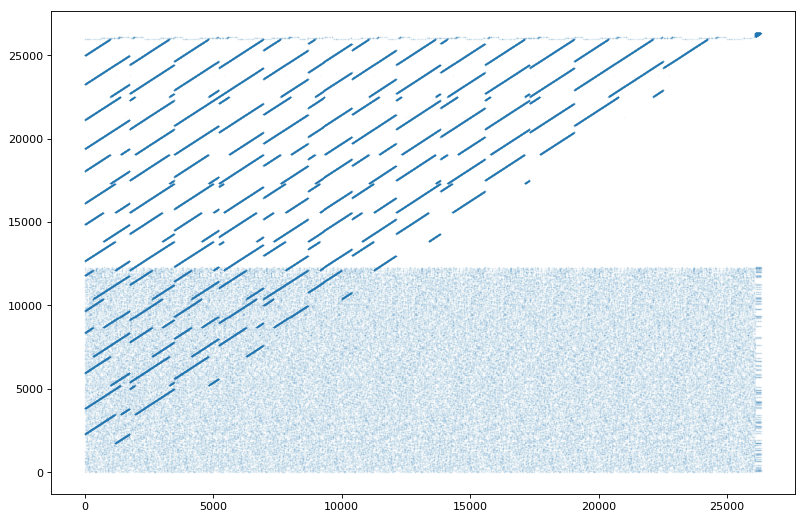

In [142]:
plt.show()

<b>clearly we see the correct labels and the noise using the scatter plot!</b><br>
lets try to figure out what is that treshold on the Y axis

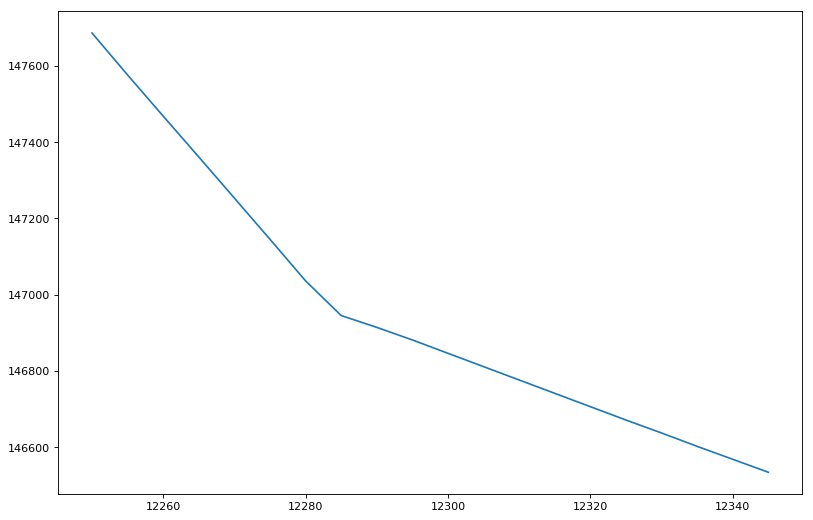

In [79]:
start, end, step = 12250, 12350, 5
occurences = [(test.SecondId > x).value_counts()[True] for x in range(start, end, step)]
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(start, end, step), occurences)
plt.show()

We can clearly see a threshold around 12280, lets take only the upper part and try to submit!

In [143]:
test["Prediction"] = test.SecondId > 12280
test["Prediction"] = test.Prediction.astype(int)
test.head()

,pairId,FirstId,SecondId,Prediction
0,0,1427,8053,0
1,1,17044,7681,0
2,2,19237,20966,1
3,3,8005,20765,1
4,4,16837,599,0


In [102]:
submission = test.loc[:,['pairId']]
submission["Prediction"] = test.Prediction
submission.to_csv("submission.csv", index=False)

This gets an incredibily high 0.89!! Can we do better?

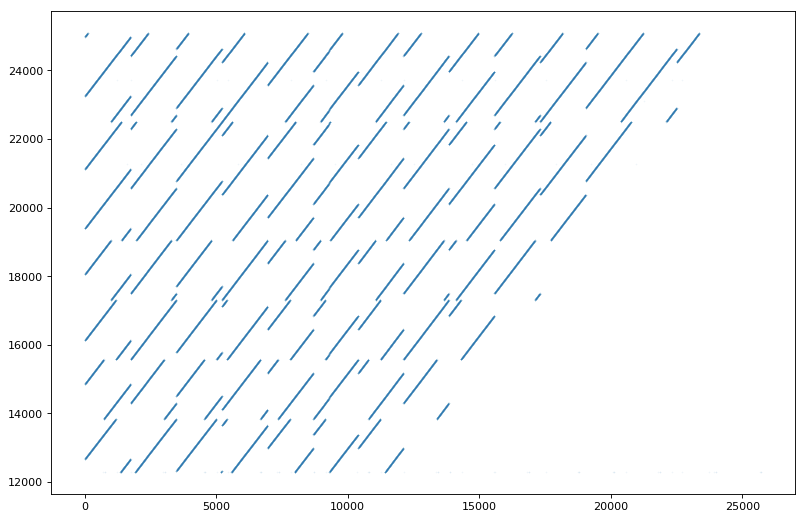

In [160]:
def scatter_result(_test):
    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(_test[_test.Prediction == 1].FirstId, _test[_test.Prediction == 1].SecondId, alpha = 0.1, s=0.1)
    plt.show()
scatter_result(test)

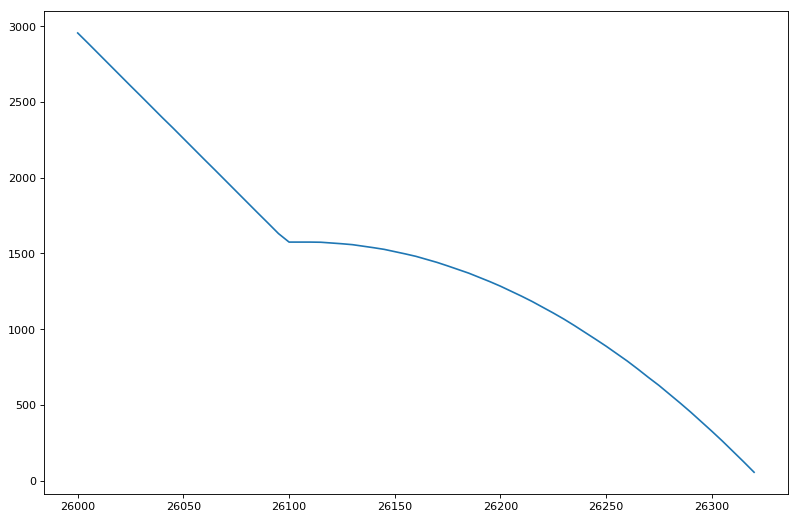

In [121]:
start, end, step = 26000, test.SecondId.max(), 5
occurences = [(test.SecondId > x).value_counts()[True] for x in range(start, end, step)]
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(start, end, step), occurences)
plt.show()

lets filter this second threshold

In [151]:
test["Prediction2"] = test.SecondId < 25090
test["Prediction3"] = test.Prediction & test.Prediction2
test = test.drop(["Prediction", "Prediction2"], axis = 1)
test = test.rename(columns = {"Prediction3":"Prediction"})
test["Prediction"] = test.Prediction.astype(int)

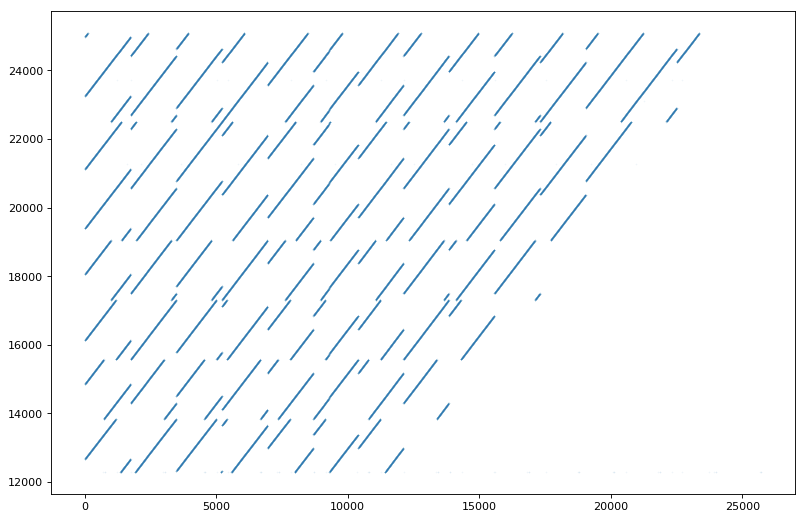

In [152]:
scatter_result()

In [154]:
submission = test.loc[:,['pairId']]
submission["Prediction"] = test.Prediction
print(submission.head())
submission.to_csv("submission.csv", index=False)

   pairId  Prediction
0       0           0
1       1           0
2       2           1
3       3           1
4       4           0


The score now is lower.. 0.85

What do this lines have in common?

In [234]:
oneline = test[(test.FirstId > 10000) & (test.FirstId < 13000) & (test.SecondId > 12380) & (test.SecondId < 12900)]

In [236]:
oneline = oneline.reset_index()

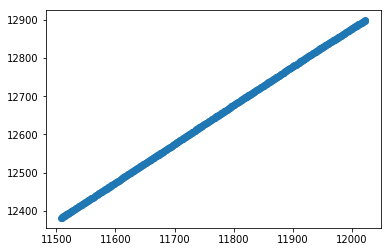

In [237]:
plt.scatter(oneline.FirstId, oneline.SecondId)
plt.show()

y = mx + c, lets estimate m and c

In [238]:
m = (oneline.loc[1].SecondId - oneline.loc[0].SecondId) / (oneline.loc[1].FirstId - oneline.loc[0].FirstId)

In [239]:
c = oneline.loc[1].SecondId - m * oneline.loc[1].FirstId

In [240]:
m, c

(0.98901098901098905, 1008.9780219780223)

In [262]:
on_line = lambda x, y : m*x + c - 10 <= y <= m*x + c + 10

In [269]:
[on_line(row.FirstId, row.SecondId) for i, row in oneline.iterrows()].count(False)

0

As just verified above, the on_line() functions returns True if the points are on the lines

Now let's try to filter the original dataset with this new threshold!

In [279]:
test = pd.read_csv('../readonly/data_leakages_data/test_pairs.csv')

In [286]:
left_side = lambda x, y:  m*x + c - 10 <= y
test["Prediction"] = left_side(test.FirstId, test.SecondId)
test["Prediction"] = test.Prediction.astype(int)

   pairId  FirstId  SecondId  Prediction
0       0     1427      8053           1
1       1    17044      7681           0
2       2    19237     20966           1
3       3     8005     20765           1
4       4    16837       599           0


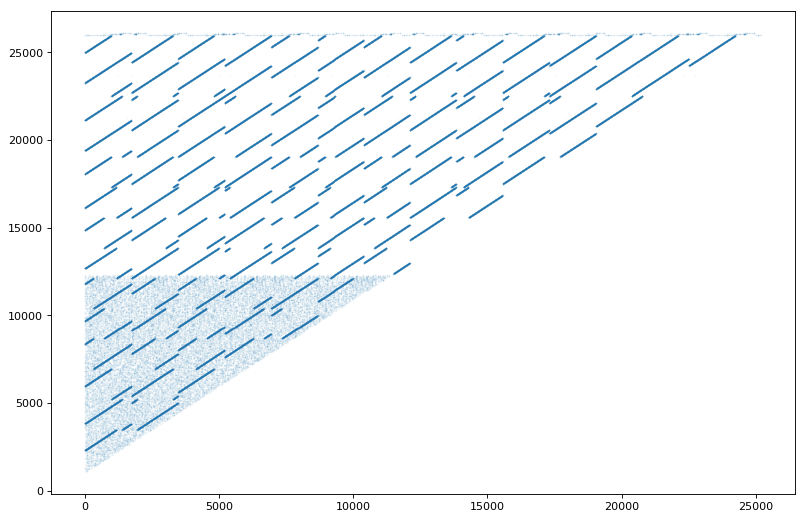

In [287]:
print(test.head())
scatter_result(test)

In [288]:
submission = test.loc[:,['pairId']]
submission["Prediction"] = test.Prediction
submission.to_csv("submission.csv", index=False)

Your accuracy score is 0.886938. It seems too low, try one more time.

So our best shot was the first easy threshold!!